In [1]:
import math
import napari
import numpy as np
import tifffile as tf

from PyQt5.QtWidgets import QFileDialog
from matplotlib import pyplot as plt

Create a Napari Viewer instance and prompt user to select image file.

In [5]:
# QFileDialog seems to require a running PyQt app
viewer = napari.Viewer()

# prompt user to select tiff file for analysis
fname = QFileDialog.getOpenFileName(None, "Open file", "C:\\Users\\lukas\\Data", "Image files (*.tif)")[0]

Confirm that the raw imaging data is either unsigned 8- or 16-bit. Convert data to floating point.

In [6]:
img = tf.imread(fname)

# confirm valid image data type
if img.dtype not in (np.uint8, np.uint16):
    print(f"Image has unsuported data type {img.dtype}")
    raise TypeError

# convert to floating point
img = img.astype(np.float64)

viewer.dims.axis_labels = ("z", "y", "x")
viewer.add_image(img, name="raw")

corrected_img_stack = []

Shift corresponding images and compare error values. Find the row shift that produces the lowest error.

In [7]:
for i in range(int(len(img)/2)):
    # subtract corresponding image slices for reference
    subtraction = img[i] - img[-i-1]

    err_baseline = np.sqrt(np.sum(np.square(subtraction)))

    # shift images by a fraction of original shape
    shift_y = math.trunc(img.shape[1]/10)

    err_y_down = np.empty((shift_y), dtype=np.float64)
    err_y_up = np.empty((shift_y), dtype=np.float64)

    err_y_down[0] = err_baseline
    err_y_up[0] = err_baseline

    # y-axis shift-down
    for r in range(1, shift_y):
        # subtract pixel values from first and last slices
        sub = img[i][:-r] - img[-i-1][r:]
        err_y_down[r] = np.sqrt(np.sum(np.square(sub)))

    # y-axis shift-up
    for r in range(1, shift_y):
        # subtract pixel values from first and last slices
        sub = img[i][r:] - img[-i-1][:-r]
        err_y_up[r] = np.sqrt(np.sum(np.square(sub)))
    
    vertex_down = np.amin(err_y_down)
    vertex_up = np.amin(err_y_up)

    if vertex_down < vertex_up:
        err_factor_y = np.where(err_y_down == vertex_down)[0][0]
        # correction_y = img[i][:-err_factor_y] - img[-i-1][err_factor_y:]
        corrected_img_stack[i] = img[i][:-err_factor_y]
        corrected_img_stack[-i-1] = img[-i-1][err_factor_y:]
        print(f"Shift down by {err_factor_y} rows")
    else:
        err_factor_y = np.where(err_y_up == vertex_up)[0][0]
        # correction_y = img[i][err_factor_y:] - img[-i-1][:-err_factor_y]
        corrected_img_stack[i] = img[i][err_factor_y:]
        corrected_img_stack[-i-1] = img[-i-1][:-err_factor_y]
        print(f"Shift up by {err_factor_y} rows")

ValueError: setting an array element with a sequence.

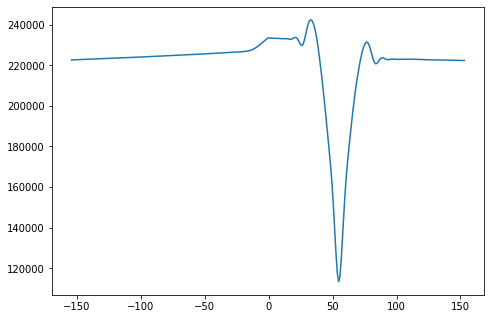

In [74]:
err_y = np.append(np.flip(err_y_down), err_y_up[1:])

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.linspace(-shift_y, shift_y-1, num=shift_y*2-1), err_y)
# fig.savefig("error_y.jpg", bbox_inches="tight")

In [76]:
for i in range(int(len(img)/2)):
    # subtract corresponding image slices for reference
    subtraction = img[i] - img[-i-1]

    err_baseline = np.sqrt(np.sum(np.square(subtraction)))

    shift_x = math.trunc(img.shape[2]/10)

    err_x_left = np.empty((shift_x), dtype=np.float64)
    err_x_right = np.empty((shift_x), dtype=np.float64)

    err_x_left[0] = err_baseline
    err_x_right[0] = err_baseline

    # x-axis shift-right
    for c in range(1, shift_x):
        # subtract pixel values from first and last slices
        sub = img[i][:, c:] - img[-i-1][:, :-c]
        err_x_right[c] = np.sqrt(np.sum(np.square(sub)))

    # x-axis shift-left
    for c in range(1, shift_x):
        # subtract pixel values from first and last slices
        sub = img[i][:, :-c] - img[-i-1][:, c:]
        err_x_left[c] = np.sqrt(np.sum(np.square(sub)))

    vertex_right = np.amin(err_x_right)
    vertex_left = np.amin(err_x_left)

    if vertex_right < vertex_left:
        err_factor_x = np.where(err_x_right == vertex_right)[0][0]
        # correction_x = img[i][:, err_factor_x:] - img[-i-1][:, :-err_factor_x]
        img[i] = img[i][:, err_factor_x:]
        img[-i-1] = img[-i-1][:, :-err_factor_x]
        print(f"Shift right by {err_factor_x} columns")
    else:
        err_factor_x = np.where(err_x_left == vertex_left)[0][0]
        # correction_x = img[i][:, :-err_factor_x] - img[-i-1][:, err_factor_x:]
        img[i] = img[i][:, :-err_factor_x]
        img[-i-1] = img[-i-1][:, err_factor_x:]
        print(f"Shift right by {err_factor_x} columns")

Shift right by 9 columns
Shift right by 4 columns


In [ ]:
err_x = np.append(np.flip(err_x_right), err_x_left[1:])

fig = plt.figure()
ax = fig.add_axes([0, 0, 1, 1])
ax.plot(np.linspace(-shift_x, shift_x-1, num=shift_x*2-1), err_x)
# fig.savefig("error_x.jpg", bbox_inches="tight")

In [ ]:
viewer.add_image(img, name="processed")